In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import librosa.display
import scipy
import copy

In [2]:
def read_raw_mat(filename,col,format='f4',end='l'):
    f = open(filename,'rb')
    if end=='l':
        format = '<'+format
    elif end=='b':
        format = '>'+format
    else:
        format = '='+format
    datatype = np.dtype((format,(col,)))
    data = np.fromfile(f,dtype=datatype)
    f.close()
    if data.ndim == 2 and data.shape[1] == 1:
        return data[:,0]
    else:
        return data

In [3]:
class Audio:
    def __init__(self, hparams):
        self.hparams = hparams
        self._mel_basis = self._build_mel_basis()

        self.min_level_db = np.array(hparams.min_level_db, np.float32) if hparams.stft_pad_center else np.array(
            hparams.min_level_db_no_center_padding, np.float32)

        self.max_level_db = np.array(hparams.max_level_db, dtype=np.float32) if hparams.stft_pad_center else np.array(
            hparams.max_level_db_no_center_padding, np.float32)

        self.average_mgc = np.array(hparams.average_mgc, dtype=np.float32)

        self.stddev_mgc = np.array(hparams.stddev_mgc, dtype=np.float32)

        self.average_mel_level_db = np.array(hparams.average_mel_level_db, dtype=np.float32)

        self.stddev_mel_level_db = np.array(hparams.stddev_mel_level_db, dtype=np.float32)

    def _build_mel_basis(self):
        n_fft = (self.hparams.num_freq - 1) * 2
        return read_raw_mat(midi_filter_bank_dir, self.hparams.num_freq)

    def load_wav(self, path):
        return librosa.core.load(path, sr=self.hparams.sample_rate)[0]

    def save_wav(self, wav, path):
        scipy.io.wavfile.write(path, self.hparams.sample_rate, wav)

    def trim(self, wav):
        unused_trimed, index = librosa.effects.trim(wav, top_db=self.hparams.trim_top_db,
                                                    frame_length=self.hparams.trim_frame_length,
                                                    hop_length=self.hparams.trim_hop_length)
        num_sil_samples = int(
            self.hparams.num_silent_frames * self.hparams.frame_shift_ms * self.hparams.sample_rate / 1000)
        start_idx = max(index[0] - num_sil_samples, 0)
        stop_idx = min(index[1] + num_sil_samples, len(wav))
        trimed = wav[start_idx:stop_idx]
        return trimed

    def silence_frames(self, wav, trim_frame_length, trim_hop_length):
        unused_trimed, index = librosa.effects.trim(wav, top_db=self.hparams.trim_top_db,
                                                    frame_length=self.hparams.trim_frame_length,
                                                    hop_length=self.hparams.trim_hop_length)
        num_start_frames = int((index[0] - trim_frame_length + trim_hop_length) / trim_hop_length)
        num_start_frames = max(num_start_frames - self.hparams.num_silent_frames, 0)
        num_stop_frames = int(((len(wav) - index[1]) - trim_frame_length + trim_hop_length) / trim_hop_length)
        num_stop_frames = min(num_stop_frames + self.hparams.num_silent_frames, len(wav))
        return num_start_frames, num_stop_frames

    def spectrogram(self, y):
        D = self._stft(y)
        S = self._amp_to_db(np.abs(D)) - self.hparams.ref_level_db
        return self._normalize_linear(S)

    def melspectrogram(self, y):
        D = self._stft(y)  # np.ndarray [shape=(1 + n_fft/2, n_frames), dtype=dtype]
        S = self._amp_to_db(self._linear_to_mel(np.abs(D))) - self.hparams.ref_level_db
        return S

    def mel_and_lenear_spectrogram(self, y):
        D = self._stft(y)
        S_linear = self._amp_to_db(np.abs(D)) - self.hparams.ref_level_db
        S_mel = self._amp_to_db(self._linear_to_mel(np.abs(D))) - self.hparams.ref_level_db
        return S_mel.astype(np.float32), self._normalize_linear(S_linear).astype(np.float32)

    def _stft(self, y):
        n_fft, hop_length, win_length = self._stft_parameters()
        return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

    def _stft_parameters(self):
        n_fft = (self.hparams.num_freq - 1) * 2
        hop_length = int(self.hparams.frame_shift_ms / 1000 * self.hparams.sample_rate)
        win_length = int(self.hparams.frame_length_ms / 1000 * self.hparams.sample_rate)
        return n_fft, hop_length, win_length

    def _linear_to_mel(self, spectrogram):
        return np.dot(self._mel_basis, spectrogram)

    def _amp_to_db(self, x):
        return 20 * np.log10(np.maximum(1e-5, x))

    def _normalize_linear(self, S):
        return (S - (self.hparams.min_level_db_linear - self.hparams.ref_level_db)) / (
                self.hparams.max_level_db_linear - self.hparams.min_level_db_linear)

    def normalize_mel(self, S):
        return (S - self.average_mel_level_db) / self.stddev_mel_level_db

    def normalize_mgc(self, S):
        return (S - self.average_mgc) / self.stddev_mgc

In [4]:
class Hparams_class:

    def __init__(self):

        # Audio
        self.num_mels=80
        self.num_freq=(4096 * 4 // 2) + 1
        self.sample_rate=24000
        self.frame_length_ms=50
        self.frame_shift_ms=12
        self.melmax=12000
        self.min_level_db=[-74.57315, -75.15253, -76.03441, -78.94658, -81.45658, -83.16649,
                           -83.84445, -85.05476, -86.15373, -87.1514, -86.76168, -89.99988,
                           -87.53151, -89.28831, -90.07161, -91.91993, -91.806366, -92.56033,
                           -90.63516, -91.38212, -91.08972, -91.6219, -91.98326, -90.30261,
                           -91.9398, -93.129776, -92.1941, -91.103294, -91.237175, -90.78438,
                           -91.53093, -90.41927, -92.43927, -92.59601, -92.152855, -91.962166,
                           -92.0386, -92.702095, -91.6633, -91.883316, -91.210335, -93.2905,
                           -92.77245, -92.19466, -91.65475, -93.4892, -91.71548, -92.84352,
                           -93.08509, -91.7138, -91.27751, -90.948654, -90.97334, -92.13456,
                           -90.750015, -91.36831, -91.16547, -90.24535, -90.84691, -91.38072,
                           -91.12708, -91.99755, -90.95061, -91.2558, -90.93501, -91.101295,
                           -91.20819, -91.10382, -91.62216, -90.38802, -90.81866, -91.53151,
                           -91.26455, -91.780075, -93.06215, -92.71509, -93.65292, -92.626976,
                           -92.53514, -93.5261, ]
        
        self.max_level_db=[-8.7983885, -0.67165875, 15.474539, 22.243866, 25.418854,
                           24.481726, 25.46931, 25.479084, 23.578905, 24.819307,
                           24.663065, 24.114887, 22.965757, 22.170685, 18.984808,
                           20.363468, 22.462925, 23.480673, 24.414461, 23.593521,
                           23.012936, 22.221502, 22.205893, 20.332628, 19.045744,
                           17.604427, 18.286837, 18.40607, 18.426083, 17.420778,
                           17.541248, 15.561689, 16.411665, 14.684055, 11.801461,
                           12.432267, 12.491672, 15.032827, 10.81222, 9.953572,
                           7.256136, 8.260053, 4.7085757, 1.8016953, -0.69460267,
                           3.0003037, 4.9585385, 5.1721506, 4.2042837, 3.9094055,
                           3.3918922, 4.2774787, 4.829912, 5.621483, 3.8970368,
                           4.382067, 2.3596873, 2.066362, 1.2526987, 1.855074,
                           3.2701375, 2.7853818, 3.2088678, 5.4290214, 6.7267404,
                           4.2379303, 2.768989, 2.899824, 2.9686077, -2.3506477,
                           -6.2867002, -11.610581, -13.612191, -16.503035, -18.795216,
                           -20.82981, -22.437883, -25.789299, -27.926609, -31.672832, ]

        self.min_level_db_no_center_padding=[-74.2863, -71.00259, -73.789764, -78.7646, -82.596245, -81.63933,
                                             -84.68395, -86.055084, -84.882484, -87.41371, -87.32541, -90.44646,
                                             -90.21648, -89.735, -89.061035, -89.918335, -91.17532, -92.02539,
                                             -92.25519, -91.71751, -93.34156, -89.73075, -90.606155, -94.89252,
                                             -91.39621, -92.47066, -91.70884, -90.780495, -90.71564, -89.956535,
                                             -91.91698, -91.800896, -91.03681, -91.68791, -91.45115, -91.38198,
                                             -90.98573, -93.38481, -91.70586, -91.98553, -91.86269, -92.08888,
                                             -91.07885, -93.221176, -92.32581, -92.867775, -91.80706, -91.43421,
                                             -91.65877, -91.88065, -92.07983, -91.240486, -91.65496, -92.04286,
                                             -90.71593, -91.44809, -91.10259, -90.54506, -91.053085, -91.47424,
                                             -91.48869, -92.15374, -90.89047, -90.83892, -91.19224, -91.45049,
                                             -91.51312, -91.09312, -91.059425, -90.69373, -90.6176, -91.973145,
                                             -91.54086, -92.08525, -92.73568, -92.82616, -93.94892, -92.4842,
                                             -92.3018, -93.2897, ]
        self.max_level_db_no_center_padding=[-12.004241, -0.59154403, 15.51294, 22.3059, 25.314339,
                                             24.596294, 25.491142, 25.619255, 23.259346, 24.58089,
                                             24.83746, 24.125889, 22.748993, 22.201448, 19.25409,
                                             20.701958, 22.218357, 23.266764, 24.47527, 23.64544,
                                             23.11356, 22.227594, 22.205093, 20.104528, 19.266384,
                                             17.671873, 18.448885, 18.681286, 18.47116, 17.56537,
                                             17.367163, 15.924866, 15.81139, 14.985402, 12.693444,
                                             12.31261, 11.994841, 15.544026, 11.341483, 9.49708,
                                             7.187513, 7.8588614, 4.2135553, 1.893847, -0.8940344,
                                             2.3510494, 4.046296, 5.089176, 3.803841, 3.8104281,
                                             3.08712, 4.5838175, 4.758815, 5.0395317, 4.245637,
                                             3.4964092, 1.9498591, 2.1272242, 1.6577126, 1.6102394,
                                             3.0944698, 2.9891176, 2.9028702, 5.4645977, 6.045552,
                                             4.37942, 3.0176723, 2.584919, 2.8786392, -2.4359074,
                                             -6.412625, -11.292816, -13.08701, -16.154442, -18.713606,
                                             -20.764845, -22.503113, -25.213186, -27.631964, -31.653187, ]

        self.ref_level_db=20.0
        self.min_level_db_linear=-100.0
        self.max_level_db_linear=25.0
        self.trim_top_db=30
        self.trim_frame_length=1024
        self.trim_hop_length=256
        self.num_silent_frames=4
        self.stft_pad_center=True

        # WaveNet
        self.min_level_db_wavenet=-100.0
        self.ref_level_db_wavenet=20.0
        self.average_mel_level_db=[0.0]
        self.stddev_mel_level_db=[0.0]

        # MGC
        self.max_mgc=[9.490147, 4.931733, 2.9839857, 2.4550848, 1.705447, 1.80223,
                      1.1765846, 1.3517053, 1.0055344, 1.3941675, 1.0031723, 1.109293,
                      0.84704036, 1.0032986, 0.8058068, 0.705852, 0.83338284, 0.95475256,
                      0.6087944, 1.1511894, 0.75893974, 0.61146086, 0.74780005, 0.5530638,
                      0.649679, 0.589487, 0.50731987, 0.5627599, 0.6055649, 0.49664104,
                      0.5991182, 0.54993206, 0.46509942, 0.46250093, 0.5683621, 0.5330769,
                      0.44675714, 0.5238732, 0.4271165, 0.38694182, 0.44473994, 0.39642242,
                      0.42751104, 0.41789263, 0.35198823, 0.40176126, 0.3598852, 0.3566597,
                      0.3035662, 0.3580775, 0.26858094, 0.3397894, 0.2654516, 0.31047392,
                      0.31237596, 0.2765144, 0.32815123, 0.2409697, 0.32625386, 0.2613224, ]
        self.min_mgc=[-1.5172987, -2.5430224, -2.6354547, -1.9412888, -2.0938659, -1.4542779,
                      -1.559637, -1.2494618, -1.4933771, -0.93512845, -1.150009, -1.0570122,
                      -1.0395083, -0.6959851, -1.1163747, -0.9716525, -0.8279374, -0.65472037,
                      -0.77350307, -0.51137847, -0.70470315, -0.6400099, -0.56438196, -0.92744607,
                      -0.68783516, -0.45931998, -0.55723035, -0.5008349, -0.52987534, -0.5158997,
                      -0.4662775, -0.46729422, -0.46662176, -0.41643453, -0.3818322, -0.4063829,
                      -0.4577983, -0.4036656, -0.4166253, -0.41005135, -0.3454493, -0.509676,
                      -0.4116756, -0.343382, -0.33104262, -0.34785527, -0.38103604, -0.2751337,
                      -0.3682833, -0.26065826, -0.36669713, -0.26149106, -0.40326032, -0.2826124,
                      -0.33796608, -0.3182397, -0.23473018, -0.3225746, -0.263121, -0.30889282, ]
        self.average_mgc=[4.41972293e+00, 2.02329754e+00, 1.11736559e-01, 4.95891616e-01,
                          -6.49257508e-03, 1.10505207e-01, -1.12790520e-01, 1.14452160e-01,
                          -2.51681908e-01, 1.45557414e-01, -1.08544787e-01, 2.99021184e-02,
                          -6.93656255e-02, 8.23475249e-02, -4.11358459e-02, 2.79068330e-02,
                          -6.62446814e-02, 6.01884218e-02, -6.92858278e-02, 6.44418513e-02,
                          -3.19970997e-02, -8.96528168e-03, 3.99776080e-02, -2.38719109e-02,
                          -3.07760966e-03, 3.18069108e-02, -3.95995617e-02, 1.85847469e-02,
                          7.85620871e-03, -1.53768650e-02, 9.79995240e-03, 1.15249677e-04,
                          -8.82793120e-03, 1.43184762e-02, -1.48806696e-02, 1.05651065e-02,
                          -4.03965272e-03, -2.11352805e-03, 5.99676394e-03, -6.71297786e-03,
                          4.99795719e-03, -1.82671967e-03, -1.97151481e-03, 4.87673239e-03,
                          -6.59008190e-03, 7.89720313e-03, -1.14317231e-02, 1.66019559e-02,
                          -2.21987555e-02, 2.56120579e-02, -2.55406652e-02, 2.17058844e-02,
                          -1.50205655e-02, 7.06383723e-03, 5.46821572e-04, -6.37831392e-03,
                          9.44171342e-03, -9.25156217e-03, 6.37883816e-03, -1.53140906e-03, ]
        self.stddev_mgc=[2.6068832646211315, 1.0434885666377425, 0.5647389404751245, 0.4346551664844934, 0.2866183455736799,
                         0.28309834298659925, 0.24603261258923564, 0.21404353401243018, 0.21812459396738895, 0.21650067011825203,
                         0.15653788427424717, 0.15484247041313567, 0.13342187899948585, 0.1270320295869481, 0.12278748436122787,
                         0.11222999286826517, 0.10983417503539046, 0.1045244500452135, 0.10445750036987145, 0.09532786570354805,
                         0.08555314636867163, 0.08437851278584173, 0.08797087609805138, 0.07882301403949897, 0.07430109350883116,
                         0.07460629700930847, 0.07517948112306423, 0.06858784348378795, 0.06677311987641323, 0.06647668641223703,
                         0.061517810658141256, 0.05728525132328572, 0.05630764597012619, 0.0571473582689086, 0.05756084420410349,
                         0.056058942280151805, 0.053349649187223146, 0.05089634975678221, 0.050325863821802534,
                         0.051884541517251956, 0.053396766744394177, 0.05295256707912829, 0.05029857167676018,
                         0.04728104191367663, 0.045678252050808985, 0.04516862539197729, 0.04498158071792541,
                         0.04562491096811137, 0.04717098463930126, 0.04886108893246686, 0.04920658570324641, 0.04750147088138797,
                         0.04435512533359589, 0.04180174154815657, 0.041353717301715436, 0.04272032341986286,
                         0.044024917132141524, 0.043774929820959506, 0.04191544221486321, 0.03947559951773146]


In [17]:
wav_dir = '../../../../../../Desktop/NII_Intern/midi_to_audio/paper_writing/rainbow_visualization/wave-sample/maestro_natural_0.wav'
# midi_dir = '../../../nii_urmp/tts1/data/train/text_segments/3_Dan_Fl_9.npz'
midi_filter_bank_dir = '../midi_filter.bank'

In [6]:
###
sparse_matrix = scipy.sparse.load_npz(midi_dir)
midi = sparse_matrix.todense()
midi /= 127

FileNotFoundError: [Errno 2] No such file or directory: '../../../nii_urmp/tts1/data/train/text_segments/3_Dan_Fl_9.npz'

NameError: name 'midi' is not defined

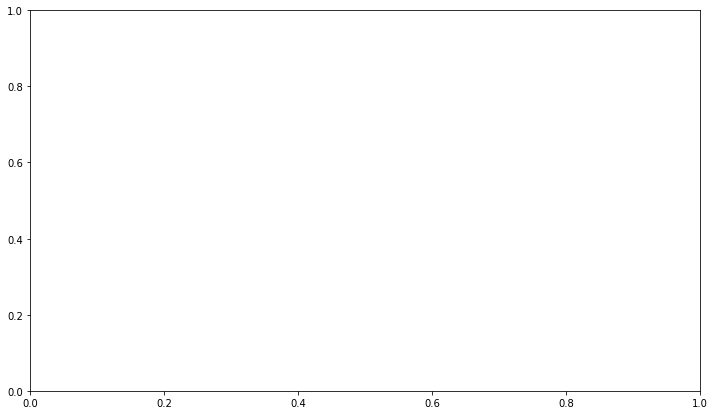

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
midi_fig = ax.pcolormesh(midi, cmap='viridis')
fig.colorbar(midi_fig, ax=ax, format='%+2.0f dB')
ax.set(title='MIDI')

In [ ]:
midi.shape

In [18]:
n_freq = (4096 * 2 // 2) + 1
n_fft = (n_freq - 1) * 2
hop_length = int(12 / 1000 * 24000)
win_length = int(50 / 1000 * 24000)
# midi_filter_bank_dir = 'midi_filter_4.bank'
mel_basis = read_raw_mat(midi_filter_bank_dir, n_freq)


In [19]:
def wav_to_spec(wav):
    stft_spec = librosa.stft(y=wav, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # mel_spec = 20 * np.log10(np.maximum(1e-5, np.dot(mel_basis, np.abs(stft_spec)))) - 20.0
    mel_spec = np.log10(np.maximum(1e-5, np.dot(mel_basis, np.abs(stft_spec))))
    mel_spec = mel_spec.astype(np.float32)
    return mel_spec


In [ ]:
# debugging
frame_length = 32 * 256
wav_psuedo = np.ones((frame_length,))
midi_spec = wav_to_spec(wav_psuedo)

In [ ]:
def wav_to_spec_torch(wav):
    stft_spec = torch.stft(input=wav, n_fft=n_fft, hop_length=hop_length, win_length=win_length, )
    # mel_spec = 20 * np.log10(np.maximum(1e-5, np.dot(mel_basis, np.abs(stft_spec)))) - 20.0
    input_power = stft_spec[..., 0] ** 2 + stft_spec[..., 1] ** 2
    input_amp = torch.sqrt(torch.clamp(input_power, min=1.0e-10))
    midi_spec = torch.matmul(input_amp.transpose(1,2), mel_basis)
    midi_spec = torch.clamp(midi_spec, min=1e-5)
    logmidi_spec = midi_spec.log10()
    return logmidi_spec

In [ ]:
import torch
mel_basis = read_raw_mat(midi_filter_bank_dir, n_freq)
mel_basis = torch.from_numpy(mel_basis.T).float()

frame_length = 32 * 256
wav_psuedo = torch.ones((1, frame_length))
midi_spec = wav_to_spec_torch(wav_psuedo)

In [ ]:
n_fft

[Text(0.5, 1.0, 'MIDI spectrogram')]

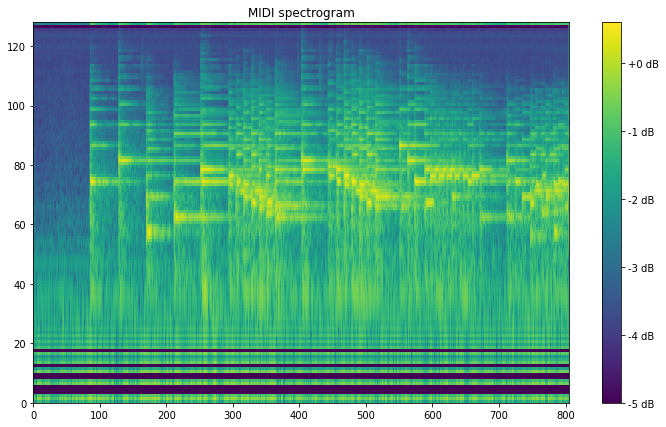

In [20]:
wav = librosa.core.load(wav_dir, sr=24000)[0]
midi_spec = wav_to_spec(wav)


fig, ax = plt.subplots(figsize=(12, 7))

midi_fig = ax.pcolormesh(midi_spec.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig, ax=ax, format='%+2.0f dB')

# ax.plot(mel_spec[:,100])
ax.set(title='MIDI spectrogram')

In [ ]:
feat_gt_npy_dir = '../debug_files/feat_gt.npy'
feat_gt_npy = np.load(feat_gt_npy_dir).T

fig, ax = plt.subplots(figsize=(12, 7))

midi_fig = ax.pcolormesh(feat_gt_npy.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig, ax=ax, format='%+2.0f dB')

# ax.plot(mel_spec[:,100])
ax.set(title='MIDI spectrogram')

In [ ]:
selected_frame = 100

fig, ax = plt.subplots(figsize=(7, 4))

midi_fig = ax.plot(midi_spec[:,selected_frame], label='midi_spec_ground-truth_std')

midi_fig_gt = ax.plot(feat_gt_npy[:,selected_frame], label='midi_spec_ground-truth_inference-in')

ax.legend()
ax.set(title='MIDI spectrogram comparison at frame :{}'.format(selected_frame))

In [ ]:
feat_tf_npy_dir = '../exp/tts_train_raw_proll/decode_train.loss.ave.teacher_forcing/test/log/output.1/denorm/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4_102.npy'
feat_tf_npy = np.load(feat_tf_npy_dir).T

fig, ax = plt.subplots(figsize=(12, 7))

midi_fig = ax.pcolormesh(feat_tf_npy.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig, ax=ax, format='%+2.0f dB')

# ax.plot(mel_spec[:,100])
ax.set(title='MIDI spectrogram (teacher forcing)')

In [ ]:
feat_fr_npy_dir = '../exp/tts_train_raw_proll/decode_train.loss.ave.free_running/test/log/output.1/denorm/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4_102.npy'
feat_fr_npy = np.load(feat_fr_npy_dir).T

fig, ax = plt.subplots(figsize=(12, 7))

midi_fig = ax.pcolormesh(feat_fr_npy.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig, ax=ax, format='%+2.0f dB')

# ax.plot(mel_spec[:,100])
ax.set(title='MIDI spectrogram (free running)')

In [ ]:
selected_frame = 97

fig, ax = plt.subplots(figsize=(7, 4))

midi_fig_fr = ax.plot(feat_fr_npy[:,selected_frame], label='midi_spec_free-running')

midi_fig_tf = ax.plot(feat_tf_npy[:,selected_frame], label='midi_spec_teacher-forcing')

ax.legend()
ax.set(title='MIDI spectrogram comparison at frame :{}'.format(selected_frame))

In [ ]:
selected_frame = 97

fig, ax = plt.subplots(figsize=(7, 4))

midi_fig_fr = ax.plot(feat_fr_npy[:,selected_frame], label='midi_spec_free-running')

midi_fig_gt = ax.plot(midi_spec[:,selected_frame], label='midi_spec_ground-truth')

ax.legend()
ax.set(title='MIDI spectrogram comparison at frame :{}'.format(selected_frame))

In [ ]:
selected_frame = 97

fig, ax = plt.subplots(figsize=(7, 4))

midi_fig_tf = ax.plot(feat_tf_npy[:,selected_frame], label='midi_spec_teacher-forcing')

midi_fig_gt = ax.plot(midi_spec[:,selected_frame], label='midi_spec_ground-truth')

ax.legend()
ax.set(title='MIDI spectrogram')

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15, 15))

midi_fig_fr = ax[0].pcolormesh(feat_fr_npy.astype(np.float32), label='free running', cmap='viridis')
fig.colorbar(midi_fig_fr, ax=ax[0], format='%+2.0f dB')

midi_fig_tf = ax[1].pcolormesh(feat_tf_npy.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig_tf, ax=ax[1], format='%+2.0f dB')

midi_fig_gt = ax[2].pcolormesh(midi_spec.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig_gt, ax=ax[2], format='%+2.0f dB')


In [ ]:
wav = librosa.core.load(wav_dir, sr=24000)[0]
midi_spec = wav_to_spec(wav)


wav = librosa.core.load(wav_dir, sr=24000)[0]
array = copy.deepcopy(wav)
array -= array.min()
array *= 2.0/array.max()
array -= 1.0
wav_norm = array
midi_spec_norm = wav_to_spec(wav_norm)


fig, axs = plt.subplots(2, 1, figsize=(7, 9))

midi_fig = axs[0].pcolormesh(midi_spec.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig, ax=axs[0], format='%+2.0f dB')

midi_fig_norm = axs[1].pcolormesh(midi_spec_norm.astype(np.float32), cmap='viridis')
fig.colorbar(midi_fig_norm, ax=axs[1], format='%+2.0f dB')

# ax.plot(mel_spec[:,100])
ax.set(title='MIDI spectrogram')

In [ ]:
selected_frame = 100

fig, ax = plt.subplots(figsize=(7, 4))

midi_fig = ax.plot(midi_spec[:,selected_frame], label='midi')

midi_fig_norm = ax.plot(midi_spec_norm[:,selected_frame], label='midi_norm')

ax.legend()
ax.set(title='MIDI spectrogram')

In [ ]:
GENDIR = '/Users/shixuan/REPO/midi_to_audio/egs2/maestro/tts1/exp/tts_train_raw_proll_v2_200epoch/decode_train.loss.ave.free_running/test/log/output.1/denorm'
WAVEID = 'MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1'

feat_buck = []
for i in range(10):
    feat_dir = os.path.join(GENDIR, WAVEID + '_{}.npy'.format(i))
    feat_buck.append(np.load(feat_dir))
    
feat_all = np.concatenate(feat_buck, axis=0).T

fig, ax = plt.subplots(figsize=(18, 7))
feat_all = ax.pcolormesh(feat_all.astype(np.float32), cmap='viridis')
fig.colorbar(feat_all, ax=ax, format='%+2.0f dB')


In [ ]:
np.save('/Users/shixuan/Desktop/NII_Intern/musicgeneration/listen_sample/midifbank_input.npy', feat_all)

In [ ]:
WAVDIR = '/Users/shixuan/Desktop/NII_Intern/musicgeneration/listen_sample/free_running'
WAVID = 'MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1_free-running_dr05.wav'

wavdir = os.path.join(WAVDIR, WAVID)
wav_gen = librosa.core.load(wavdir, sr=24000)[0]
midi_spec_gen = wav_to_spec(wav_gen)

fig, ax = plt.subplots(figsize=(18, 7))
feat_all_gen = ax.pcolormesh(midi_spec_gen.astype(np.float32), cmap='viridis')
fig.colorbar(feat_all, ax=ax, format='%+2.0f dB')

In [ ]:
WAVDIR = '/Users/shixuan/Desktop/NII_Intern/musicgeneration/listen_sample/ground_truth'
WAVID = 'MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.wav'

wavdir = os.path.join(WAVDIR, WAVID)
wav_gt = librosa.core.load(wavdir, sr=24000)[0]
midi_spec_gt = wav_to_spec(wav_gt)

fig, ax = plt.subplots(figsize=(18, 7))
feat_all_gt = ax.pcolormesh(midi_spec_gt.astype(np.float32), cmap='viridis')
fig.colorbar(feat_all_gt, ax=ax, format='%+2.0f dB')

In [ ]:
selected_frame = 1500

fig, ax = plt.subplots(figsize=(7, 4))

midi_fig_fr = ax.plot(midi_spec_gt[:,selected_frame], label='gt')

midi_fig_gt = ax.plot(midi_spec_gen[:,selected_frame], label='gen')

ax.legend()
ax.set(title='MIDI spectrogram comparison at frame :{}'.format(selected_frame))